In [ ]:
import freud
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import signac
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
hoomd.context.initialize("")

In [ ]:
itic_path= "/home/erjank_project/itic-project/"
itic_project = signac.get_project(itic_path)
ptb7_path= "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
ptb7_project = signac.get_project(ptb7_path)
#specify which project (itic or ptb7)
project = ptb7_project

In [ ]:
state_dict= {"size": "small",
             "density": 0.8,
             "kT_reduced": 1.0,
             "molecule": "PTB7_5mer_smiles",
             "process": "quench"}

job_list= project.find_jobs(state_dict)
for job in job_list:
    job_path = job.fn('trajectory.gsd')

In [ ]:
def atom_type_pos(snap, atom_type):
    if not isinstance(atom_type, list):
        atom_type = [atom_type]
    positions = []
    for atom in atom_type:
        indices = np.where(snap.particles.typeid == snap.particles.types.index(atom))
        positions.append(snap.particles.position[indices])
    return np.concatenate(positions)

## Diffraction Pattern

In [ ]:
f = gsd.pygsd.GSDFile(open(job_path, "rb"))
t = gsd.hoomd.HOOMDTrajectory(f)
last_frame = [-1]
frame = len(t)
snap = hoomd.data.gsd_snapshot(job_path, frame-1)
points = snap.particles.position
box = freud.Box.from_box(snap.box)
dp = freud.diffraction.DiffractionPattern(grid_size=1024,
                                  output_size=1024)
dp.compute((box, points), view_orientation=np.array([1,0,0,0]))

### Diffraction Pattern with select atom types

In [62]:
def dp_from_gsd(job_path, start=-30, stop=-1, atom_type='f'):
    f = gsd.pygsd.GSDFile(open(job_path, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    positions = []
    frame = len(trajectory)
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:]
        else:
            atom_positions = atom_type_pos(frame, atom_type)
        positions.append(atom_positions)
    dp = freud.diffraction.DiffractionPattern(grid_size=1024,
                                  output_size=1024)
    dp.compute((box, points), view_orientation=np.array([1,0,0,0]))
    return dp

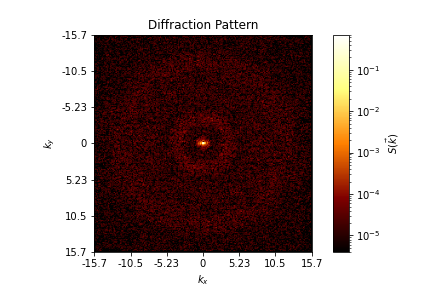

<Figure size 432x288 with 0 Axes>

In [64]:
snap = hoomd.data.gsd_snapshot(job_path, frame-1)
points = snap.particles.position
box = freud.Box.from_box(snap.box)
dp = dp_from_gsd(job.fn('trajectory.gsd'), atom_type='f')
dp.compute((box, points), view_orientation=np.array([1,0,0,0]))

NameError: name 'system' is not defined

### universal code play

In [ ]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions

def msd_from_gsd(gsdfile, start=-30, stop=-1, atom_type='all', msd_mode = "direct"):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f) 
    positions = []
    for frame in trajectory[start:stop]:
        if atom_type == 'all':
            atom_positions = frame.particles.position[:] 
        else:
            atom_positions = atom_type_pos(frame, atom_type) 
        positions.append(atom_positions) 
    msd = freud.msd.MSD(box=trajectory[-1].configuration.box, mode=msd_mode)
    msd.compute(positions)
    f.close()
    return(msd.msd)

#calculate rdf and save as .txt file
def rdf_from_gsd(job_path,
                 atom_types='all', 
                 r_max = None, 
                 r_min= 0.1, 
                 nbins= 50, 
                 start= 95):
    try: 
        f = gsd.pygsd.GSDFile(open(job_path, "rb"))
    except PermissionError:
        return None
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    if len(trajectory[start:]) <1: 
        print('two fewer frames')
        return None
    for frame in trajectory[start:-10]:
        if atom_types == 'all':
            freud_rdf.compute(frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset=False)
            
    x = freud_rdf.bin_centers
    y = freud_rdf.rdf
    #Be aware of atom type naming with multiple atom types in function
    filename = job.fn('{}-trajectory.txt'.format(atom_types[0]))
    np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
    f.close()
    return freud_rdf

In [ ]:
#calculate msd and save as .txt file
def msd_constant_density(state_dict, atom_types):
    state_dict['density.$lt'] = 1.3
    state_dict['kT_reduced.$lt'] = 1.3
    job_list = project.find_jobs(state_dict)
    fig = plt.figure()
    ax = plt.subplot(111)
    color = plt.cm.coolwarm(np.linspace(0, 1, len(job_list)))
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
    for kT,job in job_list.groupby('kT_reduced'):
        job = list(job)[0]
        msd = msd_from_gsd(job.fn('trajectory.gsd'), atom_type='ss')
        y = msd
        tspf = job.sp['n_steps'] / 100
        x = np.arange(0, len(y), 1) * tspf
        plt.plot(x, y, label=kT)
        plt.title("MSD of PTB7 temperatures at %sden" % (job.sp['density']))
        plt.xlabel("timesteps", fontsize=14)
        plt.ylabel("msd", fontsize=14)
        plt.legend(bbox_to_anchor=(1, 0.5), ncol=2)
        filename = job.fn('{}-trajectory-msd.txt'.format(atom_types[0]))
        np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "msd, timesteps")
        
def rdf_plot(job_list):
    for job in job_list:
        job_path= job.fn('trajectory.gsd')
        rdf_from_gsd(job_path, atom_types= ['ss'], start =0)
        txt_path= job.fn('ss-trajectory-gwen.txt')
    line= np.genfromtxt(txt_path, names=True, delimiter=",")
    x= line["bin_centers"]
    y= line["rdf"]
    plt.title("PTB7 fluorine at %skT %sden" % (job.sp['kT_reduced'], job.sp['density']), fontsize=16)
    plt.xlabel("distance r (A.U.)", fontsize=14)
    plt.ylabel("G(r)", fontsize=14)
    plt.plot(x, y)

In [ ]:
#save slope as timesteps to job.doc
#project = signac.get_project("ptb7-project")
#state_dict = {'size': 'small', 'process': 'quench'}
#job_list = project.find_jobs(state_dict)
#for job in job_list:
#    msd = msd_from_gsd(job.fn('trajectory.gsd'))
#    y = msd[-15:]
#    tspf = job.sp['n_steps'] / 100
#    x = np.arange(0, len(y), 1) * tspf
#    slope, intercept, r_value, p_value, std_err = linregress(x, y)
#    job.doc['msd_slope'] = slope
#    job.doc['msd_slope_r2'] = r_value

In [ ]:
msd_constant_density(state_dict, atom_types='ss')
#rdf_plot(job_list)

In [ ]:
print(job) 